In [1]:
import json
import math
import affine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

In [2]:
# This Python script reads a file and extracts metadata keys from it. 

#with open("D:\\ABoVE\\ang20180814t224053_rfl_v2r2\\ang20180814t224053_corr_v2r2_img.hdr","r") as f:
#with open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img.hdr","r") as f:
#    print("Metadata keys:\n"+", ".join(
#        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))

with open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20170809t232252\\ang20170809t232252_rdn_v2p9\\ang20170809t232252_rdn_v2p9_img.hdr","r") as f:
    print("Metadata keys:\n"+", ".join(
        [ln.strip().split(" = ")[0] for ln in f.readlines() if " = " in ln]))



Metadata keys:
description, samples, lines, bands, header offset, file type, data type, interleave, byte order, map info, crosstrack scatter file, wavelength units, flat field file, wavelength file, wavelength, radiance version, fwhm, rcc file, smoothing factors, data ignore value, spectral scatter file, bad pixel map


In [3]:
# # open the ENVI file
#img = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img")
img = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20170809t232252\\ang20170809t232252_rdn_v2p9\\ang20170809t232252_rdn_v2p9_img")

nbands = img.RasterCount
nrows = img.RasterYSize
ncols = img.RasterXSize

print("\n".join(["Bands:\t"+str(nbands),"Rows:\t"+str(nrows),"Cols:\t"+str(ncols)]))


# # new March 17th 
# # Create an output GeoTIFF file
# output_tiff = "D:\\ABoVE\\OutputTIf\\ang20190728t171711_fulltiff.tif"
# driver = gdal.GetDriverByName("GTiff")
# output_dataset = driver.Create(output_tiff, ncols, nrows, nbands, gdal.GDT_Float32)

# # Loop through each band and write it to the output GeoTIFF file
# for i in range(1, nbands + 1):
#     band = img.GetRasterBand(i)
#     data = band.ReadAsArray()
#     output_band = output_dataset.GetRasterBand(i)
#     output_band.WriteArray(data)

# # Set the geotransform and projection information
# output_dataset.SetGeoTransform(img.GetGeoTransform())
# output_dataset.SetProjection(img.GetProjection())

# # Close the datasets
# img = None
# output_dataset = None

# print("Exported all bands as a single GeoTIFF file:", output_tiff)

Bands:	425
Rows:	6976
Cols:	680


In [4]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands

#bands.to_csv('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\bands.txt', sep='\t', index=False)


,Band number,Band center (nm),EM region
1,1,376.86,visible-violet
2,2,381.87,visible-violet
3,3,386.88,visible-violet
4,4,391.89,visible-violet
5,5,396.89,visible-violet
...,...,...,...
421,421,2480.50,shortwave-infrared
422,422,2485.51,shortwave-infrared
423,423,2490.52,shortwave-infrared
424,424,2495.53,shortwave-infrared


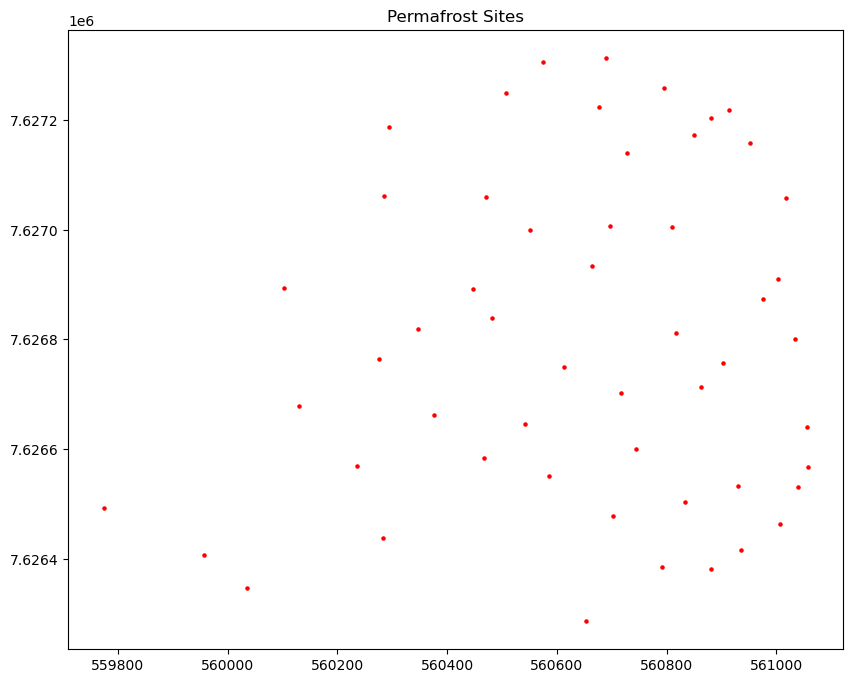

In [5]:
#
#sites = "D:\\ABoVE\\Shapefile\\TL_Permafrost_Monitoring.shp"
sites = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_pt.shp"

# open with ogr
driver = ogr.GetDriverByName("ESRI Shapefile")
permafrost_sites = driver.Open(sites, 0)

# get the first feature in the shapefile as JSON
site1 = json.loads(permafrost_sites[0].GetFeature(0).ExportToJson())
site1

import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
sites = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_pt.shp"
sites_gdf = gpd.read_file(sites)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the figure size as needed
sites_gdf.plot(ax=ax, marker='o', color='red', markersize=5)  # Plot points with red circle markers
ax.set_title('Permafrost Sites')
plt.show()


In [6]:
# from osgeo import ogr, osr
# import affine
# shapefiles have a nested structure: layer(s) -> feature(s) -> geometry
lyr = permafrost_sites.GetLayer() # get the only layer in the shapefile
feat = lyr.GetFeature(1)          # get the first feature in the layer (1 feature per site)
geom = feat.GetGeometryRef()      # get the feature's geometry

# get transform for decimal degrees
from_srs = lyr.GetSpatialRef()                                         # get shapefile srs def
to_srs = osr.SpatialReference()                                        # init ogr srs object
to_srs.ImportFromEPSG(4326)                                            # import wgs84 srs def
xytransform = osr.CoordinateTransformation(from_srs,to_srs)            # get transform object
#xytransform = osr.CoordinateTransformation(to_srs)            # get transform object

# get UTM and lat/long coordinates for each of the sites
utm_coordinate_pairs = {}
ll_coordinate_pairs = {}
for feature in lyr:
    geom = feature.GetGeometryRef()                                    # get site geometry
    utm_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY()) # get x,y utm coordinates 
    geom.Transform(xytransform)                                        # to wgs84
    ll_coordinate_pairs[feature['Name']] = (geom.GetX(), geom.GetY())  # get lon, lat
    
# get the x and y UTM coordinates for the first site
#x, y = utm_coordinate_pairs['TL_IS_2']
x, y = utm_coordinate_pairs['1']
#x, y = utm_coordinate_pairs['Alder']

affine_transform = affine.Affine.from_gdal(*img.GetGeoTransform())     # affine forward transform
inverse_transform = ~affine_transform                                  # invert transform
px, py = inverse_transform * (x, y)                                    # apply to x,y coordinates
px, py = int(px + 0.5), int(py + 0.5)                                  # get new x,y as integers

# print the three coordinates (UTM, geographic, image)
print( "\n".join(["Site 1 UTM coordinates (x,y): "+"\t"*4+str((x,y)),
       " are equal to geographic coordinates (lng,lat): \t"+str(ll_coordinate_pairs['1']),
       " and fall within image coordinates (pixel,line):\t"+str((px,py))]) )

Site 1 UTM coordinates (x,y): 				(560574.2874076627, 7627306.075519014)
 are equal to geographic coordinates (lng,lat): 	(68.7507326663779, -133.50224277848292)
 and fall within image coordinates (pixel,line):	(351, 2586)


In [7]:
# get image coordinates for each site
image_coordinate_pairs = {
    site: inverse_transform * pair for site,pair in utm_coordinate_pairs.items()}

print("site id: (col, row)")
for site,coord in image_coordinate_pairs.items():  # must convert to int to raster array  
    print(site + ": (" + str(int(coord[0] + 0.5)) + ", " + str(int(coord[1] + 0.5)) +")")

site id: (col, row)
1: (351, 2586)
2: (340, 2599)
4: (373, 2598)
5: (357, 2644)
6: (408, 2602)
7: (384, 2638)
8: (427, 2601)
9: (304, 2642)
10: (394, 2587)
11: (340, 2636)
12: (443, 2618)
13: (418, 2591)
15: (406, 2635)
16: (413, 2595)
18: (276, 2680)
19: (445, 2646)
20: (313, 2698)
21: (341, 2668)
22: (386, 2612)
23: (441, 2654)
24: (413, 2671)
25: (377, 2690)
26: (324, 2686)
27: (455, 2666)
28: (425, 2689)
29: (398, 2695)
30: (335, 2714)
33: (349, 2677)
37: (367, 2712)
38: (465, 2696)
42: (355, 2726)
44: (467, 2710)
45: (444, 2720)
46: (432, 2679)
47: (465, 2717)
48: (427, 2729)
49: (302, 2618)
50: (407, 2714)
52: (461, 2731)
53: (312, 2737)
54: (378, 2729)
55: (325, 2760)
56: (440, 2751)
57: (423, 2753)
58: (449, 2742)
59: (281, 2786)
61: (288, 2719)
62: (400, 2776)
64: (227, 2766)
68: (264, 2777)
69: (403, 2738)
70: (373, 2581)
71: (380, 2653)


In [9]:
site1name = list(image_coordinate_pairs.keys())[0]    # get name of site1
site1xy = list(image_coordinate_pairs.values())[0]    # get image coordinates of site1
px, py = int(site1xy[0] + 0.5), int(site1xy[1] + 0.5) # convert image coordinates to integers

band1_array = img.GetRasterBand(1).ReadAsArray()
print("Band 1 reflectance at site 1: "+str(band1_array[py,px]))

Band 1 reflectance at site 1: 1.4268366


In [10]:
# function gets value at input xy from input band
get_pixel = lambda img,band,y,x: img.GetRasterBand(band).ReadAsArray()[y,x]

# make a copy of the bands data frame and add reflectance column for site 1
_bands = bands
_bands[site1name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

,Band number,Band center (nm),EM region,1 reflectance
1,1,376.86,visible-violet,1.426837
2,2,381.87,visible-violet,1.315355
3,3,386.88,visible-violet,1.267234
4,4,391.89,visible-violet,1.306851
5,5,396.89,visible-violet,1.441990
6,6,401.90,visible-violet,1.911875
7,7,406.91,visible-violet,1.923139
8,8,411.92,visible-violet,2.003592
9,9,416.93,visible-violet,2.021295
10,10,421.94,visible-violet,1.980729


In [11]:
site2name = list(image_coordinate_pairs.keys())[1]    # get name of site1
site2xy = list(image_coordinate_pairs.values())[1]    # get image coordinates of site1
px, py = int(site2xy[0] + 0.5), int(site2xy[1] + 0.5) # convert image coordinates to int

_bands[site2name+" reflectance"] = [get_pixel(img,b,py,px) for b in range(1,nbands+1)]
_bands.head(10)

,Band number,Band center (nm),EM region,1 reflectance,2 reflectance
1,1,376.86,visible-violet,1.426837,1.462039
2,2,381.87,visible-violet,1.315355,1.314792
3,3,386.88,visible-violet,1.267234,1.214859
4,4,391.89,visible-violet,1.306851,1.270998
5,5,396.89,visible-violet,1.441990,1.416052
6,6,401.90,visible-violet,1.911875,1.905090
7,7,406.91,visible-violet,1.923139,1.890675
8,8,411.92,visible-violet,2.003592,1.982385
9,9,416.93,visible-violet,2.021295,1.977605
10,10,421.94,visible-violet,1.980729,1.923483


In [14]:
from tqdm import tqdm  # Import tqdm

# Read all bands data at once
band_data = [img.GetRasterBand(b).ReadAsArray() for b in range(1, nbands+1)]

# Now you can access the pixel value directly from the array in memory without reading from file
get_pixel = lambda band_data, b, y, x: band_data[b-1][y, x]

# Assuming 'bands' is a DataFrame and you want to add a new column for reflectance
# You can now use the get_pixel function with pre-loaded band_data
# Wrap range(1, nbands+1) with tqdm for a progress bar
bands[site1name + " reflectance"] = [get_pixel(band_data, b, py, px) for b in tqdm(range(1, nbands+1), desc="Processing bands")]


Processing bands: 100%|██████████████████████████████████████████████████████████████████████| 425/425 [00:00<?, ?it/s]


In [13]:
pip install tqdm

  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [19]:
bands.to_csv('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\bands_bandnumber.txt', sep='\t', index=False)

In [20]:
bands

,Band number,Band center (nm),EM region,1 reflectance,2 reflectance
1,1,376.719576,visible-violet,1.866757,1.866757
2,2,381.729576,visible-violet,1.721007,1.721007
3,3,386.739576,visible-violet,1.551000,1.551000
4,4,391.749576,visible-violet,1.609264,1.609264
5,5,396.749576,visible-violet,1.770632,1.770632
...,...,...,...,...,...
421,421,2480.359576,shortwave-infrared,0.005565,0.005565
422,422,2485.369576,shortwave-infrared,0.003393,0.003393
423,423,2490.379576,shortwave-infrared,0.005299,0.005299
424,424,2495.389576,shortwave-infrared,0.005214,0.005214


In [15]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                  59
Band center (nm)         667.36
EM region           visible-red
1 reflectance          1.270294
2 reflectance          1.270294
Name: 59, dtype: object
------------------------------------------------------------
Band number                    34
Band center (nm)           542.15
EM region           visible-green
1 reflectance            2.202362
2 reflectance            2.202362
Name: 34, dtype: object
------------------------------------------------------------
Band number                   20
Band center (nm)          472.02
EM region           visible-blue
1 reflectance           2.021463
2 reflectance           2.021463
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (6976, 680, 3)


In [16]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

print("the first 10 x coordinates:")
xarr[:10]

the first 10 x coordinates:


array([561111, 561116, 561121, 561127, 561132, 561137, 561142, 561147,
       561152, 561157])

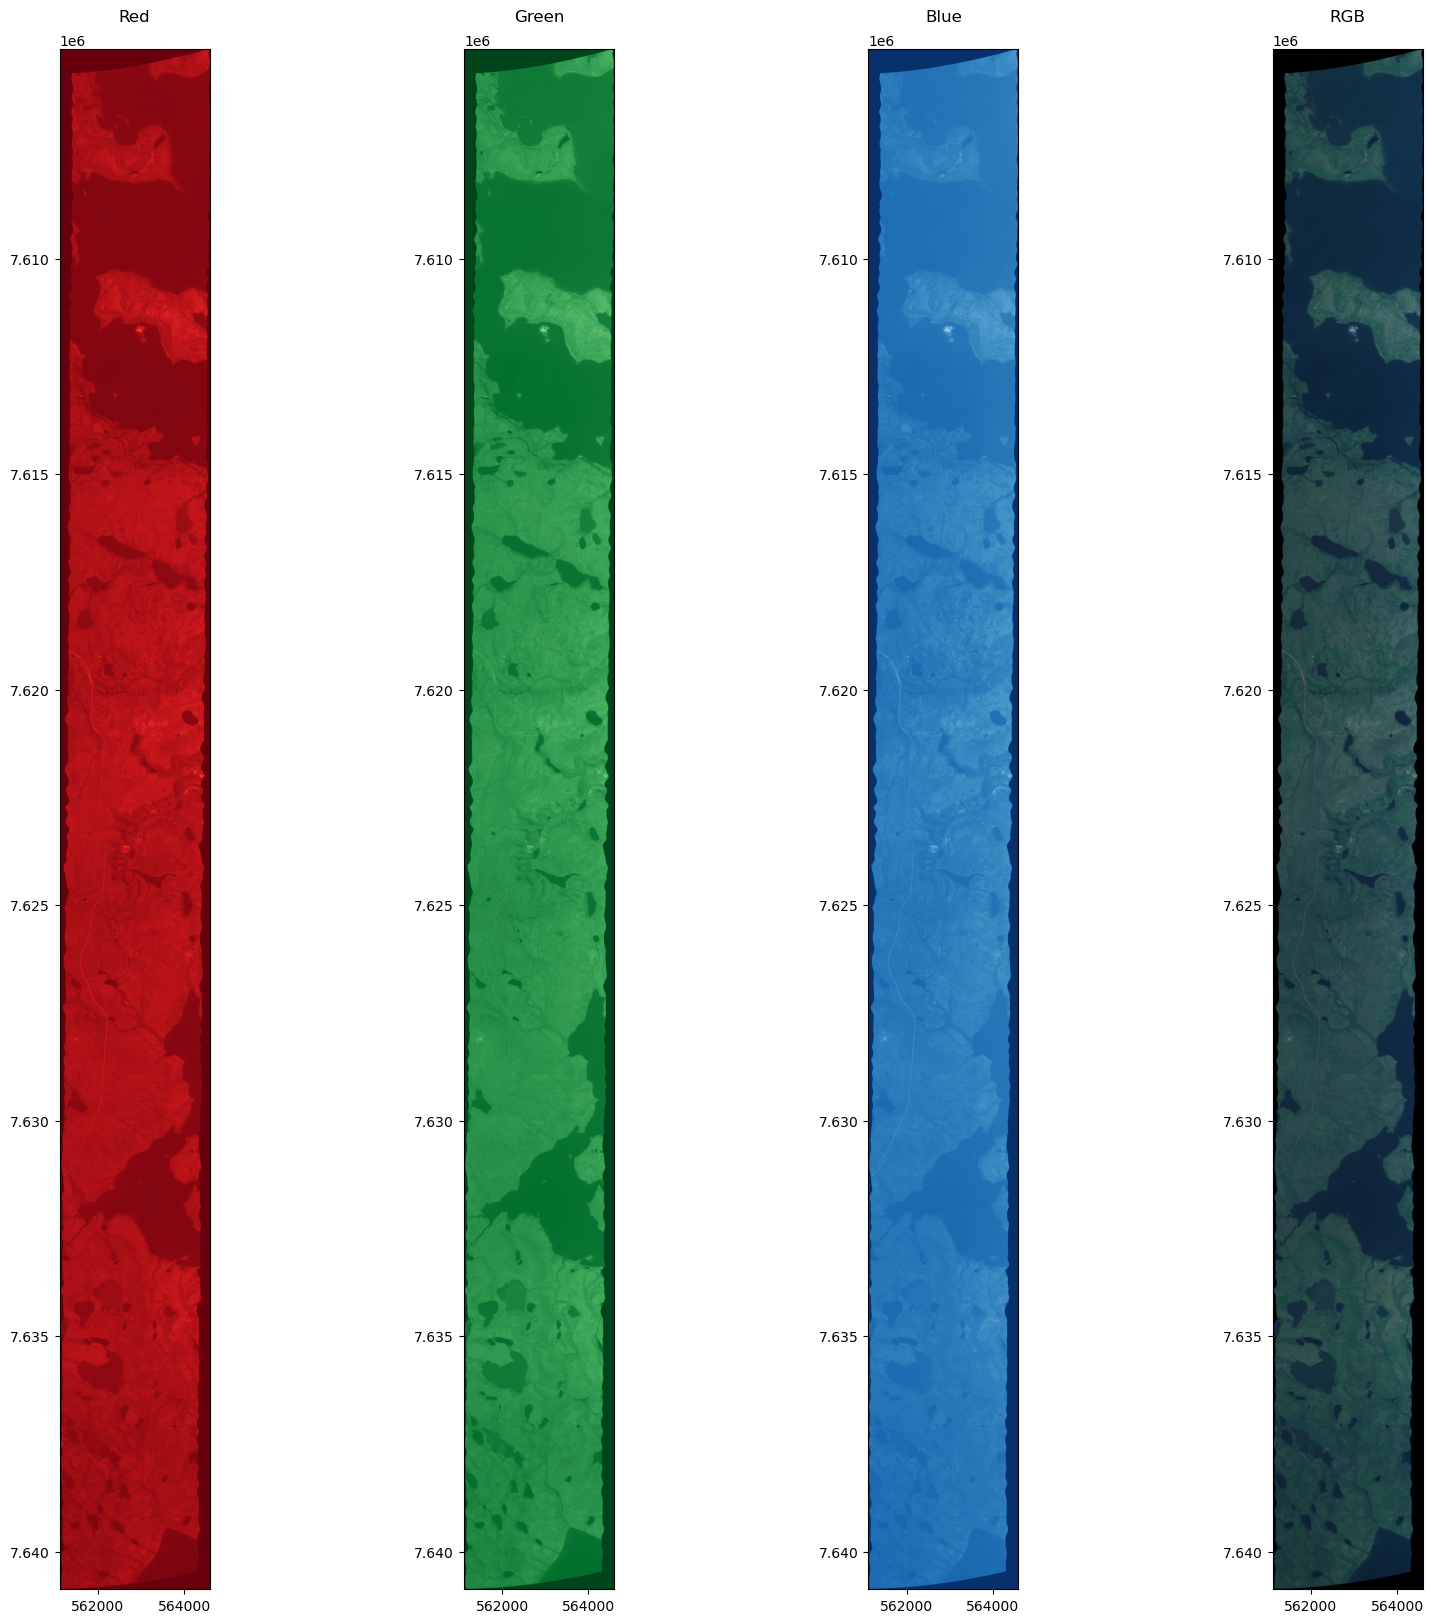

In [17]:
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)  
    

   
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite.png", dpi=300, bbox_inches='tight')


plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])

In [ ]:
# apply histogram equalization to each band
for i in range(rgb_stack.shape[2]):

    # band i
    b = rgb_stack[:,:,i]
    
    # histogram from flattened (1d) image
    b_histogram, bins = np.histogram(b.flatten(), 256)

    # cumulative distribution function
    b_cumdistfunc = b_histogram.cumsum()

    # normalize
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]

    # get new values by linear interpolation of cdf
    b_equalized = np.interp(b.flatten(), bins[:-1], b_cumdistfunc)
    
    # reshape to 2d and add back to rgb_stack
    rgb_stack[:,:,i] = b_equalized.reshape(b.shape)
    
    
# plot. all of this is matplotlib ---------->
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': rgb_stack[:,:,0], 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': rgb_stack[:,:,1], 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': rgb_stack[:,:,2], 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    
#plt.savefig("D:\\ABoVE\\Figures\\rbg_plot_StudySite_HistEqualized.png", dpi=300, bbox_inches='tight')

plt.imshow(rgb_stack)

Band number                  63
Band center (nm)     687.259576
EM region           visible-red
1 reflectance          1.264091
2 reflectance          1.264091
Name: 63, dtype: object
------------------------------------------------------------
Band number                   105
Band center (nm)       897.619576
EM region           near-infrared
1 reflectance            3.583358
2 reflectance            3.583358
Name: 105, dtype: object
------------------------------------------------------------
NDVI stats --- mean: 0.21345542, std: 0.47697926, min: -149.72453, max: 77.89506


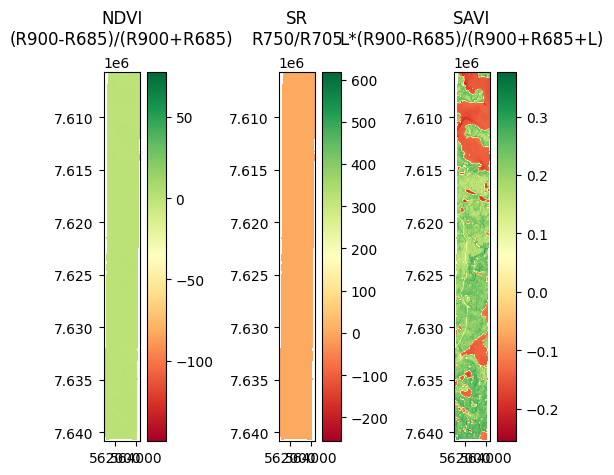

In [34]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))


# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

# calculate NDWI
R860, R1240 = get_band(get_band_number(860)), get_band(get_band_number(1240))
R860[R860 == -9999.], R1240[R1240 == -9999.] = np.nan, np.nan
ndwi_array = (R860-R1240)/(R860+R1240)



# plot. all of this is matplotlib ---------->
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=plt.get_cmap("RdYlGn"),
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20)#, fontdict = titlefont)
    plt.colorbar(p)

# Exporting Spectral Index Arrays to GeoTIFF with GDAL 

In [35]:
# WORKS - this export each single band ratio (NDVI, SR, SAVI) in arrays

# Assuming 'img' is your source raster and the arrays are already computed
arrays = {
    #"ndvi": ndvi_array,
    #"sr": sr_array,
    #"savi": savi_array,
    "ndwi": ndwi_array
}

output_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\"
file_suffix = "_ang20190728t171711_rdn_v2v2_img.tif"

# Set geotransform and projection from the source image
geo = img.GetGeoTransform()
wkt = img.GetProjection()

for key, array in arrays.items():
    # Replace NaN with no-data value
    array[np.isnan(array)] = -9999.

    # Create the output file path
    output_file = f"{output_path}{key}{file_suffix}"

    # Open GDAL raster dataset for writing
    outraster = gdal.GetDriverByName('GTiff').Create(
        output_file, 
        img.RasterXSize, 
        img.RasterYSize, 
        1, 
        gdal.GDT_Float32
    )

    # Set geotransform and projection
    outraster.SetGeoTransform(geo)
    outraster.SetProjection(wkt)

    # Get the first band and write the array
    outraster_band = outraster.GetRasterBand(1)
    outraster_band.WriteArray(array)
    outraster_band.SetNoDataValue(-9999)

    # Write out and close the file
    outraster.FlushCache()
    outraster = None

print("Done!")


Done!


# CLIP indicies to study site 

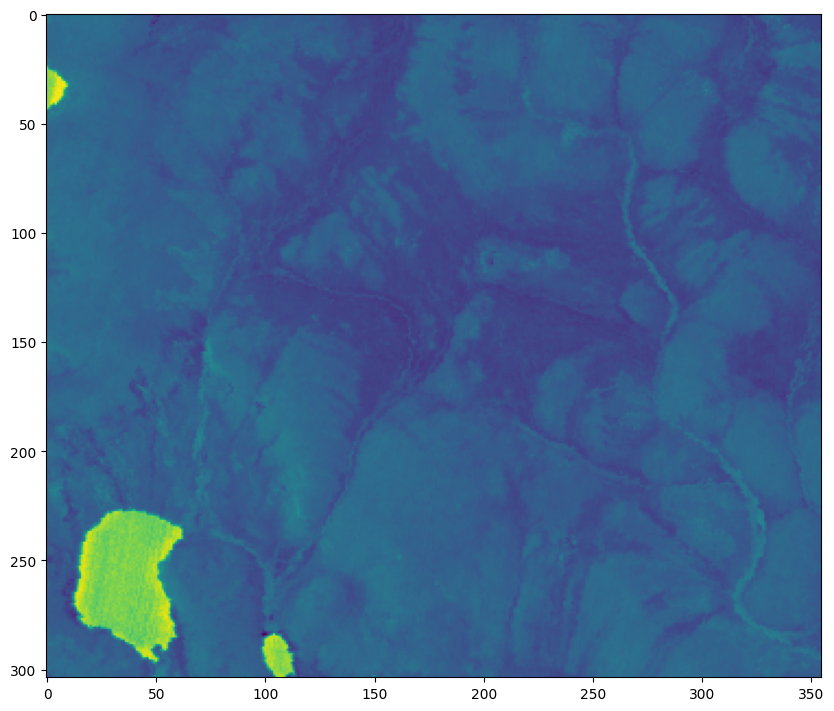

In [36]:
import os
from osgeo import ogr, gdal
import numpy as np
import matplotlib.pyplot as plt

extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(extent)
lyr = shp.GetLayer()

# List of input GeoTIFF files
input_files = [
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20190728t171711_rdn_v2v2_img.tif",
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20190728t171711_rdn_v2v2_img.tif",
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20190728t171711_rdn_v2v2_img.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20190728t171711_rdn_v2v2_img.tif"

]

# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_CLIPPED.tif"

    # Perform clipping
    outraster = gdal.Warp(
        output_file,
        input_file,
        format='GTiff',
        cutlineDSName=extent,
        cutlineLayer=lyr.GetName(),
        cropToCutline=True,
        dstNodata=-9999
    )

    # Plot the clipped image
    plt.rcParams['figure.figsize'] = [10, 10]
    clipped_img = outraster.GetRasterBand(1).ReadAsArray()
    clipped_img[clipped_img == -9999.] = np.nan
    plt.imshow(clipped_img)
    plt.show()


In [ ]:
# to wgs

In [37]:
import os
from osgeo import ogr, gdal, osr
import numpy as np
import matplotlib.pyplot as plt

watershed = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\Watershed_NGEE_Arctic_Seward_Peninsula_Teller_20171211.shp"
extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open shapefile
shp = ogr.Open(watershed)
lyr = shp.GetLayer()

# List of input GeoTIFF files
input_files = [
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndvi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
    #"C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\sr_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif",
    "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ndwi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif"

]

# Loop through input files
for input_file in input_files:
    # Output file name
    output_file = os.path.splitext(input_file)[0] + "_wgs.tif"

    # Open the clipped image
    img = gdal.Open(input_file)

    # Initialize OSR spatial reference object for WGS84
    outsrs = osr.SpatialReference()
    outsrs.ImportFromEPSG(4326)
    
    # Get the projection
    wkt = img.GetProjection()

    # Create virtual warped raster
    warp = gdal.AutoCreateWarpedVRT(
        img,
        wkt,
        outsrs.ExportToWkt(),
        gdal.GRA_NearestNeighbour,
        0.0
    )
    warpb = warp.GetRasterBand(1).ReadAsArray()

    # Create output raster dataset and write warped raster array
    outraster3 = gdal.GetDriverByName('GTiff').Create(
        output_file,
        warp.RasterXSize,
        warp.RasterYSize,
        1,
        gdal.GDT_Float32
    )

    outraster3.SetGeoTransform(warp.GetGeoTransform())
    outraster3.SetProjection(warp.GetProjection())
    outraster3b = outraster3.GetRasterBand(1)
    outraster3b.WriteArray(warpb)
    outraster3b.SetNoDataValue(-9999)
    outraster3.FlushCache()

    # Close open files
    img = None
    outraster3 = None
    warp = None
print("done")

done


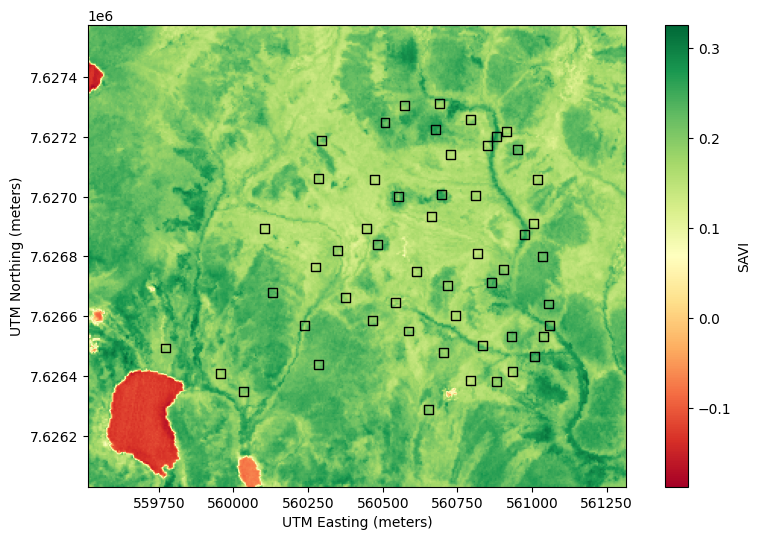

In [100]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt


shpstudysite = r"C:\Users\smdur\OneDrive\Desktop\ABoVE\Shapefile\SquareVegPlots_within_ang20190728t171711.shp"

# Open the raster file
ds = gdal.Open(r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif")
band = ds.GetRasterBand(1)  # Assuming NDWI data is in the first band
ndwi_data = band.ReadAsArray()

# Mask invalid data (e.g., -9999)
ndwi_data = np.ma.masked_where(ndwi_data == -9999, ndwi_data)

gt = ds.GetGeoTransform()
# Create arrays of x and y coordinates in pixel space
x = np.arange(0, ndwi_data.shape[1])
y = np.arange(0, ndwi_data.shape[0])

# Transform the pixel coordinates into geographic coordinates
x_coords = gt[0] + x * gt[1]
y_coords = gt[3] + y * gt[5]

# Make the coordinate arrays 2D to match the NDWI data array
x_coords, y_coords = np.meshgrid(x_coords, y_coords)

# # Plotting the data with actual geographic coordinates
# plt.figure(figsize=(10, 6))
# plt.imshow(ndwi_data, cmap='RdYlGn', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],  vmin=np.min(ndwi_data), vmax=np.max(ndwi_data))
# plt.colorbar(label='NDWI')
# plt.xlabel('UTM Easting (meters)')
# plt.ylabel('UTM Northing (meters)')

# plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\ndwi_plot2d.png', dpi=300)
# plt.show()

# Load the study site shapefile
study_site = gpd.read_file(shpstudysite)

# Plotting the NDWI data
plt.figure(figsize=(10, 6))
plt.imshow(ndwi_data, cmap='RdYlGn', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()], vmin=np.min(ndwi_data), vmax=np.max(ndwi_data))
plt.colorbar(label='SAVI')
plt.xlabel('UTM Easting (meters)')
plt.ylabel('UTM Northing (meters)')

# Plot the study site shapefile on top
study_site.plot(ax=plt.gca(), facecolor='none', edgecolor='black')

plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\savi_plot2d_studysite.png', dpi=300)
plt.show()

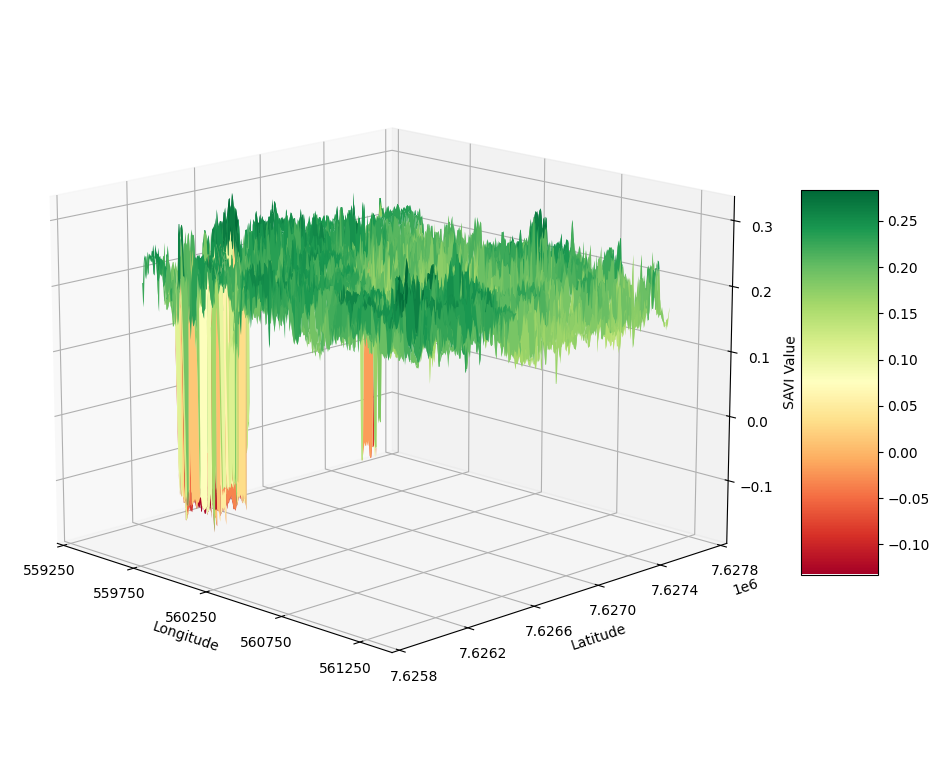

In [87]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Open the raster file and read the NDWI data
ds = gdal.Open(r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\savi_ang20190728t171711_rdn_v2v2_img_CLIPPED.tif")
ndwi_data = ds.GetRasterBand(1).ReadAsArray()

# Get geotransform and calculate coordinates
gt = ds.GetGeoTransform()
x = np.arange(ndwi_data.shape[1])
y = np.arange(ndwi_data.shape[0])
x_coords = gt[0] + x * gt[1]
y_coords = gt[3] + y * gt[5]

x_coords, y_coords = np.meshgrid(x_coords, y_coords)

# 3D Surface plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_coords, y_coords, ndwi_data, cmap='RdYlGn', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5)

#ax.set_title('NDWI')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('SAVI Value')

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
#ax.grid(False)
ax.view_init(elev=15, azim=-45)
plt.savefig('C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Figures\\savi_plot3d.png', dpi=300)
plt.show()




In [ ]:
import os
from osgeo import ogr, gdal
import matplotlib.pyplot as plt



dataset = gdal.Open("C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\ang20190728t171711\\ang20190728t171711_rdn_v2v2\\ang20190728t171711_rdn_v2v2_img")



# Path to the shapefile
extent = "C:\\Users\\smdur\\OneDrive\\Desktop\\ABoVE\\Shapefile\\SquareVegPlots_within_ang20190728t171711_SquareBuffer.shp"

# Open the shapefile
shp = ogr.Open(extent)
lyr = shp.GetLayer()



# Output file name for the clipped raster
#output_file = os.path.splitext(data_file)[0] + "_CLIPPED_FULL.tif"
output_file = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20190728t171711_clipped_fullstack.tif"
print(output_file)


# Perform clipping
outraster = gdal.Warp(
    output_file,
    dataset,
    format='GTiff',
    cutlineDSName=extent,
    cutlineLayer=lyr.GetName(),
    cropToCutline=True,
    dstNodata=-9999
)

# # Assuming you want to display the result
# # Open the clipped raster
# clipped_raster = gdal.Open(output_file)
# band_count = clipped_raster.RasterCount

# # Plotting each band of the clipped image
# plt.rcParams['figure.figsize'] = [10, 10]
# for band in range(1, band_count + 1):
#     band_data = clipped_raster.GetRasterBand(band).ReadAsArray()
#     plt.imshow(band_data)
#     plt.title(f'Band {band}')
#     plt.show()
print("done")

In [ ]:
import rasterio
import imageio

# Path to the TIFF file
tif_path = "C:\\Users\\smdur\\OneDrive\\Desktop\\scratchABOVE\\ang20190728t171711_clipped_fullstack.tif"

# Open the TIFF file
with rasterio.open(tif_path) as src:
    # Loop through each band
    for i in range(1, src.count + 1):
        # Read the band
        band = src.read(i)
        
        # Normalize the band data to 8-bit (0-255)
        normalized_band = (255 * (band - band.min()) / (band.max() - band.min())).astype('uint8')
        
        # Write the band as an image
        image_path = f"band_{i}.png"
        imageio.imwrite(image_path, normalized_band)
        
# Convert the images to a GIF
images = [imageio.imread(f"band_{i}.png") for i in range(1, src.count + 1)]
gif_path = "bands.gif"
imageio.mimsave(gif_path, images, duration=0.5)

print("GIF created successfully!")


In [2]:
import spectral

"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20190728t171711_clipped_fullstack.tif"

In [15]:
from spectral import *

# Load a sample hyperspectral image provided by the spectral library
img = open_image(r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20190728t171711_clipped_fullstack.tif")

# # Load the associated spectral library
# spectral.settings.envi_support_nonlowercase_params = True
# lib = spectral.open_image(spectral.envi.examples.get_path('jasperRidge2.sli'))

# # Display the hyperspectral image
# view = spectral.imshow(img, (29, 19, 9))  # These indices (29, 19, 9) are example band numbers

# # To view the spectral library
# spectral.plot_spectra(lib.spectra, bands=(10, 20, 30))  # These are example band numbers

# # If you want to interactively view the image in a separate window
# spectral.imshow(img, (29, 19, 9), classes=img.classes)

# # You can adjust the band numbers (29, 19, 9) to the specific bands you want to visualize


OSError: Unable to determine file type or type not supported.

IndexError: index 304 is out of bounds for axis 0 with size 304

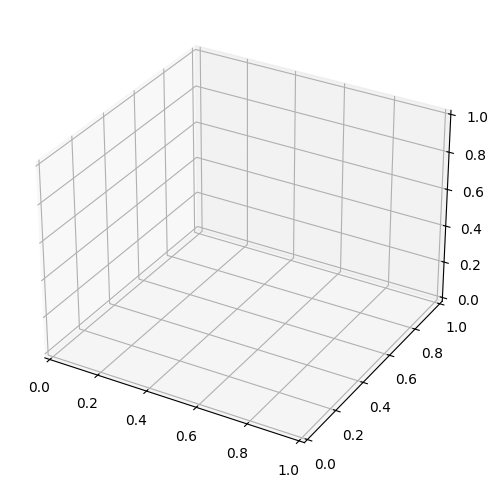

In [12]:
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Open the TIFF file using rasterio
tif_path = r"C:\Users\smdur\OneDrive\Desktop\scratchABOVE\ang20190728t171711_clipped_fullstack.tif"  # Replace with your TIFF file path
with rasterio.open(tif_path) as src:
    # Read the data as a 3D numpy array (bands, rows, columns)
    data = src.read()

# Extract dimensions from the data
bands, rows, cols = data.shape

# Create a figure and 3D axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the cube visual
for band in range(bands):
    x = np.arange(rows)
    y = np.arange(cols)
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, band)  # Set Z coordinates to the band number
    ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(data[band]), shade=False)

# Customize the plot
ax.set_xlabel('Row')
ax.set_ylabel('Column')
ax.set_zlabel('Band')
ax.set_title('Hyperspectral Cube Visual')
ax.invert_yaxis()  # Invert y-axis for correct orientation
ax.view_init(30, 120)  # Set the initial view angle

# Show the plot
plt.tight_layout()
plt.show()
